the initial variables are {'u': 0.0}
layer info  [256, 256, 1]
layer info  [256, 256, 1]
the initial variables are {'u': 0.0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1669787151_9642948/resources/0/weather.mos""&##10;"</value></ModelicaMessage>


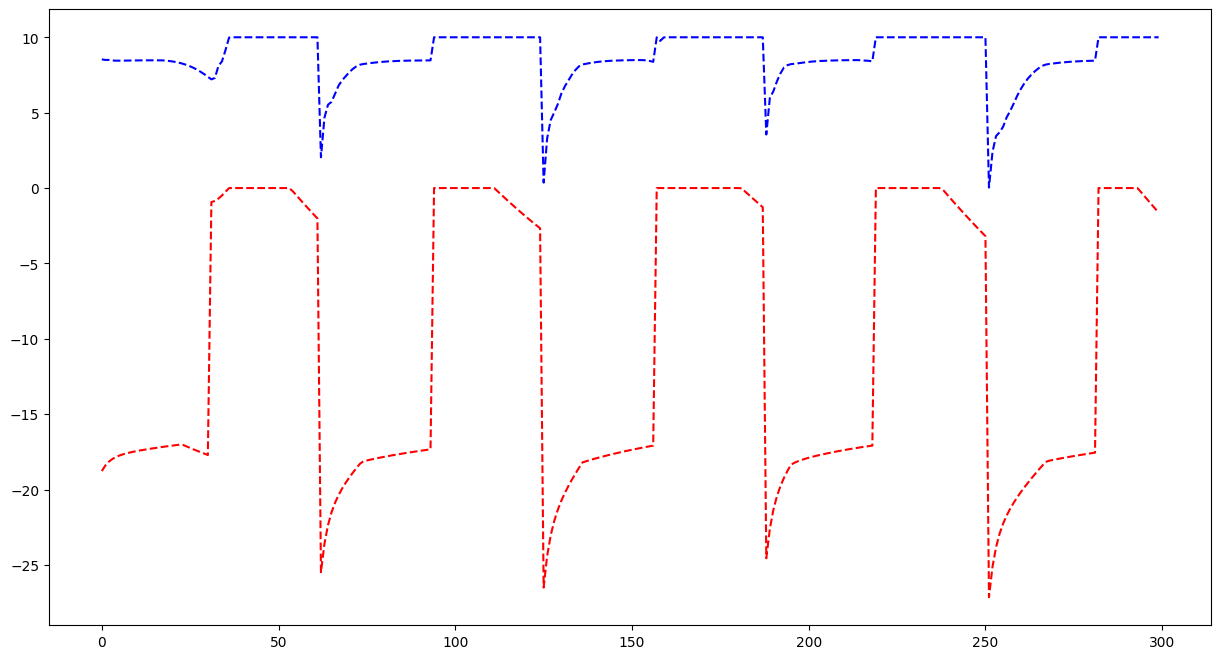

[[1.         0.79465575]
 [0.79465575 1.        ]]


Bad pipe message: %s [b"ob\xd62[\x92\x1d\xac\x89`N\xcf8A\xb8c%E \xcb\xc2\xe1\xc7S\xe3x\xb0Qg\x00\xe4h\xb3\xe1u\x93{EB\t\x91\xadl\x18E\x06\xae\xc5'$\xc1\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r"]
Bad pipe message: %s [b'\x04\x9e\xa7Q\xcf]nmF\xcc\x8a-\x1bU\xfb\xc2h\xc0\x00\x00|\xc0,\xc0']
Bad pipe message: %s [b'\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V']
Bad pipe message: %s [b'oP\xb5\x1a\xf4\xbc\x0b\x88QX\xd7\xdc{\x9c\xef\xac|\x90\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0

In [4]:
from preference_data import *
from reward_model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from buildings_factory import reward_func

# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 


building_name = "SimpleHouseRad-v0"
building_idx = buildings_list.index(building_name)
env = get_env(building_name)
inputs = get_inputs(building_name, env)
default_control = default_controls[building_idx]
env_rl = StableBaselinesRLWrapper(env, reward_func, inputs, default_control)
# input_dim = env_rl.action_space.shape[0] + 2*env_rl.observation_space.shape[0]
input_dim = env_rl.observation_space.shape[0]
model = RewardNet(input_dim)
model_loc = f"models/{building_name}/"
model.load_state_dict(torch.load(f"{model_loc}/reward_model_best.pkl"))
new_traj_reward_list = []
old_traj_reward_list = []
model.eval()
controller = controller_list[building_idx]
trajectory = sample_trajectory(env_rl, building_name, controller=controller)
traj_len = min(300, len(trajectory) // 4)
for i in range(traj_len):
    state, action, _, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    old_reward = reward_func(kpis)
    # print(old_reward, kpis)
    # print('cur_state: ', env_rl.inverse_transform_state(state))
    # print("next_state: ", env_rl.inverse_transform_state(next_state))
    old_traj_reward_list.append(old_reward)
    with torch.no_grad():
        # tran = np.concatenate((state, action, next_state))
        model_in = torch.from_numpy(np.array(state)).reshape(1, -1).to(torch.float)
        new_reward = model.get_reward(model_in)[0].item()
    new_traj_reward_list.append(new_reward)

plt.figure(figsize=(15,8))
x = list(range(len(old_traj_reward_list)))
plt.plot(x, old_traj_reward_list, 'r--', x, new_traj_reward_list, 'b--')
plt.show()
print(np.corrcoef(old_traj_reward_list, new_traj_reward_list))